In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as optimize
import os
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib widget
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [7,5]

# Load Data

In [29]:
inputs = pd.read_csv('../Data/all_inputs_cleaned.csv')
inputs.drop(['Unnamed: 0'], axis = 1, inplace = True)
inputs

,Month,CPI,InterestRate,GDP,ValAddConst,ValAddInfo,Borrowing,CommercialLoan,ConsumerLoan,Deficit,ITBPrice,ITBVol,VGTPrice,VGTVol,S&P500Price,S&P500Vol
0,2006-06-01,0.005007,0.031315,0.012731,0.016023,0.000000,-0.004089,0.178,0.054,-2.393523,-0.141342,0.058676,-0.058480,-0.357298,-0.015674,0.010319
1,2006-07-01,0.002989,0.010122,0.012731,0.016023,0.000000,0.016496,0.201,0.078,-1.361045,-0.087839,2.328675,-0.036031,0.028369,0.002547,-0.155359
2,2006-08-01,0.002484,0.050100,0.010429,0.000000,0.014294,0.007533,0.223,0.045,-1.478174,-0.021042,0.796079,0.032067,-0.368216,0.013990,0.089268
3,2006-09-01,0.005451,0.001908,0.010429,0.000000,0.014294,-0.008966,0.177,0.056,-2.616416,0.046412,2.381466,0.066667,0.267074,0.022189,-0.029398
4,2006-10-01,0.004436,0.000000,0.010429,0.000000,0.014294,-0.005700,0.222,0.074,0.951423,0.046867,-0.436061,0.044646,0.280520,0.028076,0.159019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2023-05-01,0.000530,0.038710,0.012081,0.012858,0.015515,0.166242,0.013,0.073,0.440654,0.052962,0.067876,0.038191,-0.165449,0.009060,0.254976
200,2023-06-01,0.003678,0.047619,0.011676,0.015295,0.011737,0.062205,-0.029,0.058,-1.465993,0.066633,-0.030136,0.092126,0.350401,0.034360,-0.010638
201,2023-07-01,0.001241,0.003953,0.011676,0.015295,0.011737,0.001615,-0.026,0.060,-2.364214,0.079389,0.066784,0.040382,-0.028132,0.047030,-0.146846
202,2023-08-01,0.001803,0.007874,0.011676,0.015295,0.011737,-0.016332,-0.021,0.030,-0.052340,-0.008281,0.420013,-0.034826,-0.024273,0.005205,0.156903


In [10]:
outputs = pd.read_csv('../Data/all_outputs_cleaned.csv')
outputs.drop(['Unnamed: 0'], axis = 1, inplace = True)
outputs

,Month,Construction,Information,Total_Private
0,2006-06-01,-0.001815,-0.000987,0.000744
1,2006-07-01,0.001689,-0.001647,0.001250
2,2006-08-01,0.001037,0.001320,0.001117
3,2006-09-01,-0.000259,-0.002306,0.000567
4,2006-10-01,-0.004664,-0.001321,0.000331
...,...,...,...,...
199,2023-05-01,0.003164,-0.001292,0.001916
200,2023-06-01,0.003659,-0.003235,0.000645
201,2023-07-01,0.001508,-0.006167,0.001087
202,2023-08-01,0.004519,-0.006858,0.001325


In [30]:
outputs['Month'] = pd.to_datetime(outputs['Month'])
inputs['Month'] = pd.to_datetime(outputs['Month'])

In [31]:
inputs['Year-2000'] = inputs['Month'].dt.year-2000

In [32]:
X = np.array(inputs.iloc[:, 1:])
X.shape

(204, 16)

In [33]:
d = X.shape[1]

In [34]:
y = np.array(outputs['Construction'])
# one-hot encoding on output -> percent change is positive or negative
classes = np.zeros((len(y), 2))
classes[:,0] = (y >= 0)
classes[:,1] = (y < 0)
classes.shape

(204, 2)

In [35]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.1, random_state=43)

# Feedforward NN

In [17]:
class LossPrintingCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch%10 == 0:
            #file.write("The avg loss for epoch {} is {:.6f}, lr = {:.6g}. \n".format(epoch, logs["loss"], self.model.optimizer.lr.read_value()))
            print("The avg loss for epoch {} is {:.6f}, lr = {:.6g}.".format(epoch, logs["loss"], self.model.optimizer.lr.read_value()))

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [36]:
def trainFNN(X_train, y_train, params): # params = [n_epochs, earlyStopFlag, learning rate]
    n_epochs = params[0] #epoch = one pass through training data
    earlyStopFlag = params[1]

    batchSize = max(8, X_train.shape[0]//100)
    print(f'Batch size: {batchSize}')
    
    #layer sizes
    n_inputs = d
    n_hidden1 = d*2
    n_hidden2 = d*2
    n_hidden3 = d*2
    n_hidden4 = d*2
    n_outputs = y_train.shape[1] # number of categories we want to get probabilities for in softmax
    
    if earlyStopFlag:
        callback_list = [LossPrintingCallback(), earlyStop]
    else:
        callback_list = [LossPrintingCallback()]

    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(n_hidden1, input_shape=(d,), name="hidden1", activation='relu'),
    tf.keras.layers.Dense(n_hidden2, name="hidden2", activation='relu'),
    tf.keras.layers.Dense(n_hidden3, name="hidden3", activation='relu'),
    tf.keras.layers.Dense(n_hidden4, name="hidden4", activation='relu'),
    tf.keras.layers.Dense(n_outputs, name="output", activation = 'softmax')
    ])

    model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate = params[2]),
            loss = 'mse')

    model.fit(
        x = X_train,
        y = y_train, #combo of previously learned Y and the relevant X points
        batch_size = batchSize,
        epochs = n_epochs,
        callbacks = callback_list,
        validation_split = 0.1,
        verbose = 0)
    
    return model

In [38]:
model = trainFNN(X_train, y_train, [351, False, 0.01])

Batch size: 8
The avg loss for epoch 0 is 0.217581, lr = 0.01.
The avg loss for epoch 10 is 0.148254, lr = 0.01.
The avg loss for epoch 20 is 0.125370, lr = 0.01.
The avg loss for epoch 30 is 0.115605, lr = 0.01.
The avg loss for epoch 40 is 0.097995, lr = 0.01.
The avg loss for epoch 50 is 0.133703, lr = 0.01.
The avg loss for epoch 60 is 0.118592, lr = 0.01.
The avg loss for epoch 70 is 0.108533, lr = 0.01.
The avg loss for epoch 80 is 0.104896, lr = 0.01.
The avg loss for epoch 90 is 0.120237, lr = 0.01.
The avg loss for epoch 100 is 0.124437, lr = 0.01.
The avg loss for epoch 110 is 0.105326, lr = 0.01.
The avg loss for epoch 120 is 0.099611, lr = 0.01.
The avg loss for epoch 130 is 0.100286, lr = 0.01.
The avg loss for epoch 140 is 0.109161, lr = 0.01.
The avg loss for epoch 150 is 0.082676, lr = 0.01.
The avg loss for epoch 160 is 0.089944, lr = 0.01.
The avg loss for epoch 170 is 0.137105, lr = 0.01.
The avg loss for epoch 180 is 0.112716, lr = 0.01.
The avg loss for epoch 190 i

In [39]:
y_pred = model(tf.convert_to_tensor(X_test), training = False)
y_pred_classes = np.round(y_pred)

In [40]:
1 - np.mean(np.abs(y_pred[:,0] - y_test[:,0]))

0.7031378149986267

In [41]:
np.sum(y_pred_classes[:,0] == y_test[:,0])/y_test.shape[0]

0.7619047619047619

# Recurrent Neural Network

In [88]:
T = 10 # number of steps to include

First basic attempt at making time series samples:

Let's try to redo this but with repeating sequences i.e. `[1,2,3], [2,3,4], [3,4,5]` instead of `[1,2,3], [4,5,6]` and so on...

In [172]:
N = X.shape[0] - T
X_rnn = np.zeros((N, T, X.shape[1]-1))
for t in range(T): # length of sequence
    X_rnn[:, t, :] = X[t:(-T + t), :-1]
X_rnn.shape

(194, 10, 15)

In [173]:
y_rnn = y[T:] # choose endpoint

In [174]:
y_rnn.shape

(194,)

In [175]:
# train-test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X_rnn, y_rnn, test_size=0.3, random_state=43)

In [178]:
lstm = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units = d+5, input_shape=(T,d-1), activation='relu'),
    tf.keras.layers.LSTM(5, return_sequences=True),
    tf.keras.layers.LSTM(5),
    tf.keras.layers.Dense(d+5, name="extra_dense", activation='relu'),
    tf.keras.layers.Dense(1, name="output", activation = 'linear')
    ])

In [179]:
lstm.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
    loss = 'mse')

lstm.fit(
    X2_train, 
    y2_train, 
    batch_size = 8, 
    epochs = 151,
    callbacks = [LossPrintingCallback()],
    validation_split = 0.1,
    verbose = 0)

The avg loss for epoch 0 is 0.000089, lr = 0.0001.
The avg loss for epoch 10 is 0.000051, lr = 0.0001.
The avg loss for epoch 20 is 0.000036, lr = 0.0001.
The avg loss for epoch 30 is 0.000030, lr = 0.0001.
The avg loss for epoch 40 is 0.000023, lr = 0.0001.
The avg loss for epoch 50 is 0.000020, lr = 0.0001.
The avg loss for epoch 60 is 0.000019, lr = 0.0001.
The avg loss for epoch 70 is 0.000017, lr = 0.0001.
The avg loss for epoch 80 is 0.000016, lr = 0.0001.
The avg loss for epoch 90 is 0.000015, lr = 0.0001.
The avg loss for epoch 100 is 0.000015, lr = 0.0001.
The avg loss for epoch 110 is 0.000014, lr = 0.0001.
The avg loss for epoch 120 is 0.000014, lr = 0.0001.
The avg loss for epoch 130 is 0.000013, lr = 0.0001.
The avg loss for epoch 140 is 0.000013, lr = 0.0001.
The avg loss for epoch 150 is 0.000013, lr = 0.0001.


In [180]:
y_comp = lstm(tf.convert_to_tensor(X2_train), training = False).numpy()

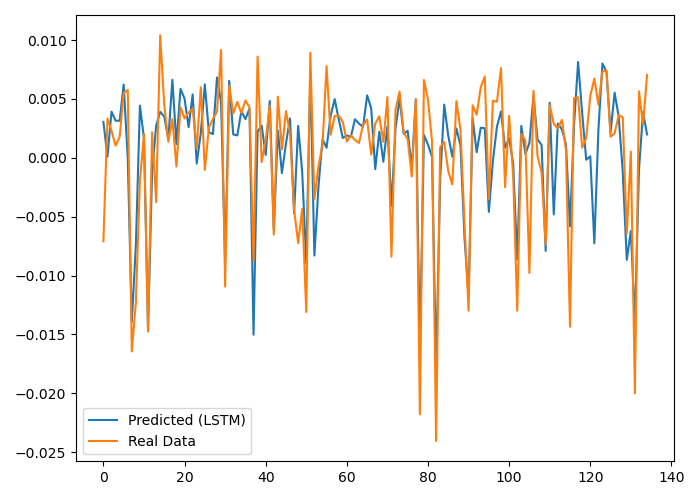

In [181]:
plt.close()
plt.plot(y_comp[:,0], label = 'Predicted (LSTM)')
plt.plot(y2_train, label = 'Real Data')
plt.legend()
plt.show()

In [182]:
y_pred = lstm(tf.convert_to_tensor(X2_test), training = False).numpy()

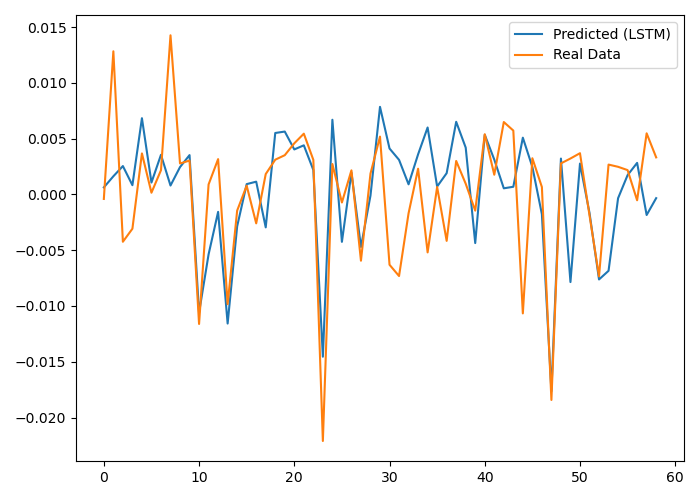

In [183]:
plt.close()
plt.plot(y_pred[:,0], label = 'Predicted (LSTM)')
plt.plot(y2_test, label = 'Real Data')
plt.legend()
plt.show()

In [184]:
a_train = (np.sign(y_comp) == np.sign(y2_train))
a_test = (np.sign(y_pred) == np.sign(y2_test))

In [185]:
np.mean(a_train)

0.6019753086419753

In [186]:
np.mean(a_test)

0.546394714162597